In [2]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
from scipy.signal import savgol_filter
import random  
import time
import io
import h5py
import tensorflow as tf
from tensorflow.keras.datasets import mnist     # MNIST dataset is onderdeel van Keras
from tensorflow.keras.models import Sequential  # Het type neuraal netwerk dat we gaan gebruiken
from tensorflow.keras.layers import Dense, Dropout, Activation  # Verschillende type lagen die we gaan gebruiken
from tensorflow.keras.optimizers import SGD, Adam, schedules
from tensorflow.keras import utils


configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=configuration)
print("done")

done


# Data prep

In [3]:
from PIL import Image

def get_pixels_val(image_path): # bron: https://stackoverflow.com/questions/138250/how-to-read-the-rgb-value-of-a-given-pixel-in-python
    """Get a numpy array of an image so that one can access values[x][y]."""
    image = Image.open(image_path, "r")
    pixel_values = np.array(image)

    # width crop
    pixel_values = pixel_values[54:-43]
    
    # height crop
    pv = list()
    for c, h in enumerate(pixel_values):
        pv.append(pixel_values[c, 35:-36])
    
    return np.array(pv)
print("done")

done


# Create transformed and halved csv file

In [4]:
# opent de og sat data file
folder = r"C:\Users\User\Documents\LUCAS2015_spectra\LUCAS2015_Soil_Spectra_EU28_v2"
with open(r"C:\Users\User\Documents\LUCAS2015_spectra\LUCAS2015_Soil_Spectra_EU28\spectra_ BE .csv") as f:
    # maakt csv reader aan
    reader = csv.reader(f)
    # Open 
    with open(folder+"\spectra_ BE .csv", 'w', newline='') as file:
        writer = csv.writer(file)
        for c, row in enumerate(reader):
            if c == 0:
                writer.writerow(row[:5] + row[205:-200:2])
            else:
                x = np.array(row[205:-200:2], dtype='float64')
                reflectance = 10**(-x)
                writer.writerow(row[:5] + list(reflectance))
print("done")

done


In [66]:
co_data_path = r"C:\Users\User\Documents\LUCAS2015_topsoildata_20200323\LUCAS_Topsoil_2015_20200323.csv"

col_list = ["Point_ID", "NUTS_0", "OC"]
df = pd.read_csv(co_data_path, usecols=col_list)
df


,Point_ID,OC,NUTS_0
0,34103754,25.5,UK
1,34443774,503.5,UK
2,35163814,51.4,UK
3,32323656,470.3,UK
4,34463934,43.1,UK
...,...,...,...
21854,45402772,49.9,AT
21855,47722672,19.4,AT
21856,45882618,53.9,AT
21857,45342706,24.2,AT


In [119]:
country = "BE"
df_country = df.loc[df['NUTS_0'] == country]
df_country["spectogram"] = np.nan
pd.options.mode.chained_assignment = None  #turns an annoying warning off, nothing important
df_country["spectogram"] = df_country["spectogram"].astype(object)

with open(folder+"\spectra_ " + country +" .csv") as fi:
    re = csv.reader(fi)
    lst = list()
    start = time.time()
    row1= np.array(next(re)[5:])

    for c, ro in enumerate(re):
        pointid = ro[2]
        print(pointid)
        reflectance = np.array(ro[5:])
        r = savgol_filter(reflectance, 11, 2)

        f, t, Sxx = signal.spectrogram(r, 1)

        sxx_sdv = np.array([[ (Sxx[i][j] - np.mean(Sxx[i]) ) / np.std(Sxx[i]) for j in range(Sxx.shape[1])] for i in range(Sxx.shape[0])])

        fig, ax = plt.subplots()
        ax.axis('off')
        ax.pcolormesh(t, f, sxx_sdv, shading='gouraud')#, shading='gouraud'

        io_buf = io.BytesIO()
        fig.savefig(io_buf, format='rgba', dpi=72)
        io_buf.seek(0)
        img_arr = np.reshape(np.frombuffer(io_buf.getvalue(), dtype=np.uint8),
                             newshape=(int(fig.bbox.bounds[3]), int(fig.bbox.bounds[2]), -1))
        io_buf.close()
        plt.close()


        array = img_arr[35:-36]
        array = array[:, 54:-43]
        array = np.delete(array[:], -1, -1)
        df_country.loc[df_country['Point_ID'] == int(pointid), ['spectogram']] = [array]


    
df_country = df_country.dropna()
df_country.to_hdf(folder+"\labeled_data.hdf5", country)
reread = pd.read_hdf(folder+"\labeled_data.hdf5")
print(time.time() - start)

# TODO: ervoor zorgen dat sneller csv gevuld word (met batches miss werken), ervoor zorgen dat het goed geprint word
# npz = np.load(r"D:\FARM_data\Soil_Spectra_s1\spectra_ BE_array.npz")

40603048
40603048
40423056
40423056
40123032
40123032
39263086
39263086
39743148
39743148
38543096
38543096
38463096
38463096
38203100
38203100
38143104
38143104
38103106
38103106
38543122
38543122
38523118
38523118
38083120
38083120
38043130
38043130
38263134
38263134
38863068
38863068
38583090
38583090
38603088
38603088
39003046
39003046
39063046
39063046
39642992
39642992
39563076
39563076
39883048
39883048
39863070
39863070
40243026
40243026
40103044
40103044
39783064
39783064
40203054
40203054
40003082
40003082
40603038
40603038
40383036
40383036
40363052
40363052
39943050
39943050
40463040
40463040
39702984
39702984
39622978
39622978
39663000
39663000
40023022
40023022
39762996
39762996
40203018
40203018
40163006
40163006
40062984
40062984
39602980
39602980
39443068
39443068
39383058
39383058
39563058
39563058
39523056
39523056
39803036
39803036
39663018
39663018
39303032
39303032
39483050
39483050
39083090
39083090
39123108
39123108
39203112
39203112
39803096
39803096
38983116
3

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:2606: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['NUTS_0', 'spectogram'], dtype='object')]

  pytables.to_hdf(


53.726999044418335


In [30]:
#print(lst[0])
thisdict =	{}
print(thisdict)

{}


In [33]:
f = h5py.File(folder+"\mytestfile.hdf5", "w")

In [34]:
f.create_dataset('BE', data=lst)

<HDF5 dataset "BE": shape (10, 217, 335, 3), type "|u1">

In [35]:
f.close()

In [36]:
hf = h5py.File(folder+"\mytestfile.hdf5", 'a')

In [37]:
n1 = hf.get('BE')

In [38]:
print(n1)
hf.close()

<HDF5 dataset "BE": shape (10, 217, 335, 3), type "|u1">


In [115]:
# TODO: Labelen van Spectogram arrays + opsplitsen train en test?(kan miss ook met train_test_split), 
# Het opstellen van een model

df_country.to_hdf(folder+"\mytestfile.hdf5", 'BE')
reread = pd.read_hdf(folder+"\mytestfile.hdf5")
print('done')


done


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:2606: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['NUTS_0', 'spectogram'], dtype='object')]

  pytables.to_hdf(


In [ ]:
# # Bron: https://www.pythoninformer.com/python-libraries/numpy/numpy-and-images/
# img = Image.open('image.jpeg')
# array = np.array(img)
# array = array[35:-36] #54:-43
# array = array[:, 54:-43]
# invimg = Image.fromarray(array)
# invimg.save('TRANSFORM.jpeg')

In [117]:
print(reread)

       Point_ID    OC NUTS_0  \
3924   39743148   2.3     BE   
3925   39543124  22.4     BE   
3926   39483040  15.2     BE   
3927   39883092  11.9     BE   
3928   39763078   8.6     BE   
...         ...   ...    ...   
21554  39563058  11.4     BE   
21555  39523056  14.3     BE   
21556  39803036  10.0     BE   
21557  40203018  35.8     BE   
21558  38183132  34.3     BE   

                                              spectogram  
3924   [[[62, 74, 137], [62, 74, 137], [62, 74, 137],...  
3925   [[[66, 64, 134], [66, 64, 134], [66, 64, 134],...  
3926   [[[66, 65, 134], [66, 65, 134], [66, 65, 134],...  
3927   [[[69, 53, 129], [69, 53, 129], [69, 53, 129],...  
3928   [[[65, 66, 135], [65, 66, 135], [65, 66, 135],...  
...                                                  ...  
21554  [[[62, 74, 137], [62, 74, 137], [62, 74, 137],...  
21555  [[[65, 66, 135], [65, 66, 135], [65, 66, 135],...  
21556  [[[63, 72, 137], [63, 72, 137], [63, 72, 137],...  
21557  [[[69, 53, 129], [

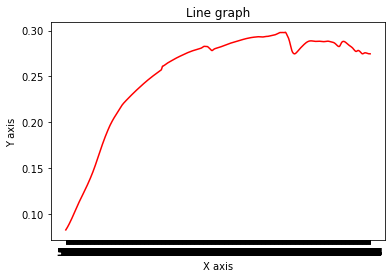

In [45]:
plt.title("Line graph") 
plt.xlabel("X axis") 
plt.ylabel("Y axis") 
plt.plot(row1, r, color ="red") 
plt.show()

In [ ]:
            
#                 print(array)
            #lst.append(array)
#         print(len(lst))
            
# -80 sec (100)
#             plt.savefig(f'image.jpeg')

#             img = Image.open('image.jpeg')
#             print(type(img))
# -3 sec (100)
#             array = np.array(img)
#             array = array[35:-36]
#             array = array[:, 54:-43]
# - 3 sec (100)
#             lst.append(array)
#         np.savez(fil, *lst)

# Create npz file with train and test data